# Notebook 16: Best-fit plane

In [notebook 4](nb4_three_points.ipynb), we looked at the problem of calculating the orientation of a plane from three points on the plane. But what if we have more than three points on the plane? We can use the least squares approach of [notebook 15](nb15_bestfit_fold_axis.ipynb) to solve this problem ([Allmendinger, 2020](https://pubs.geoscienceworld.org/gsa/geosphere/article/16/6/1495/591697/GMDE-Extracting-quantitative-information-from)). This also allows evaluating the goodness of fit of the plane to the data points. Let’s assume the points are defined by position vectors $\mathbf{p}[i]$ in an east-north-up ($\mathbf{ENU}$) coordinate system. First, the centroid $\mathbf{c}$ of the position vectors $\mathbf{p}[i]$ is calculated:

$$\mathbf{c}=\frac{\sum_{i=1}^n \mathbf{p}_{[i]}}{n}$$

Then, the centroid $\mathbf{c}$ is substracted from the position vectors $\mathbf{p}[i]$:

$$\mathbf{s}_{[i]}=\mathbf{p}_{[i]}-\mathbf{c}$$

And we use the vectors $\mathbf{s}[i]$ to construct a covariance matrix $\mathbf{C}$ (which looks very similar to the orientation matrix $\mathbf{T}$ in [notebook 15](nb15_bestfit_fold_axis.ipynb)):

$$\mathbf{C}=\left[\begin{array}{ccc}\sum\left(s_E\right)_{[i]}^2 & \sum\left(s_E\right)_{[i]}\left(s_N\right)_{[i]} & \sum\left(s_E\right)_{[i]}\left(s_U\right)_{[i]} \\ \sum\left(s_N\right)_{[i]}\left(s_E\right)_{[i]} & \sum\left(s_N\right)_{[i]}^2 & \sum\left(s_N\right)_{[[]}\left(s_U\right)_{[i]} \\ \sum\left(s_U\right)_{[i]}\left(s_E\right)_{[i]} & \sum\left(s_U\right)_{[i]}\left(s_N\right)_{[i]} & \sum\left(s_U\right)_{[i]}^2\end{array}\right]$$

Finally, the eigenvalues and eigenvectors of the covariance matrix $\mathbf{C}$ are determined. The eigenvector corresponding to the smallest eigenvalue is the pole to the best-fit plane, and the square root of the smallest eigenvalue is the standard deviation of the distance of each point from the best-fit plane.

## Python function

The function [fit_plane](../functions/fit_plane.py) calculates the best-fit plane to a group of lines.

## Application

[Michie et al. (2021)](https://library.seg.org/doi/abs/10.1190/INT-2021-0077.1) published an interesting article in which they compare ML and manual fault interpretation methods. In this notebook, we will use interpretation data (both manual and ML) from the Vette fault in the Horda Platform (North Sea). Especifically, we will use the fault data picked every line both manually and using ML (Figure 4a of [Michie et al., 2021](https://library.seg.org/doi/abs/10.1190/INT-2021-0077.1)). These data were kindly provided by [Emma Michie](https://www.liverpool.ac.uk/people/emma-michie), and are anonymized by making the origin of the data at zero.

Let's start by loading the manual and ML fault data. In the fault data files, the first column is east, the second column is north, and the third column is depth, all in meters. For our analyisis, we will use elevation instead of depth, so we multiply the third column of the manual and ML data by -1:

In [1]:
import sys, os
import numpy as np

# read manual fault data
path = os.path.join('..', 'data', 'Vette_fault', 'manual_fault.txt')
manual_fault = np.loadtxt(path)
# 3rd column is depth but make it elevation
manual_fault[:,2] = manual_fault[:,2] * -1

# read ML fault data
path = os.path.join('..', 'data', 'Vette_fault', 'ML_fault.txt')
ML_fault = np.loadtxt(path)
# 3rd column is depth but make it elevation
ML_fault[:,2] = ML_fault[:,2] * -1

Now let's plot the manual and ML fault data:

In [2]:
# import plotly express
import plotly.express as px

fig = px.scatter_3d(x=manual_fault[:,0], y=manual_fault[:,1], 
                    z=manual_fault[:,2], width=800, height=600)
# set the marker size
fig.update_traces(marker_size = 2)
# set the title
fig.update_layout(title=f'Manual fault data, {manual_fault.shape[0]} points')
# axes of equal scale and no color scale
fig.update_layout(scene_aspectmode='data')
# show the figure
fig.show()

In [3]:
# plot ML fault
fig = px.scatter_3d(x=ML_fault[:,0], y=ML_fault[:,1], 
                    z=ML_fault[:,2], width=800, height=600)
# set the marker size
fig.update_traces(marker_size = 2)
# set the title
fig.update_layout(title=f'ML fault data, {ML_fault.shape[0]} points')
# axes of equal scale and no color scale
fig.update_layout(scene_aspectmode='data')
# show the figure
fig.show()

As you can see the ML fault data has 3.5 times as much points as the manual fault data. The ML data is more irregular and perhaps more inaccurate than the manual fault data. [Michie et al. (2021)](https://library.seg.org/doi/abs/10.1190/INT-2021-0077.1) used unconstrained triangulation to fit a surface to the data, and compute orientations (strikes and dips) from the triangles (Figures 5a and 6a of [Michie et al., 2021](https://library.seg.org/doi/abs/10.1190/INT-2021-0077.1)).

In this notebook, I'll try something different. Let's instead make a regular grid of points on the fault surface, and sample the fault orientation at those points. The two cells below construct and display the regular grids on the manual and ML interpreted fault data. Notice that the X (east) and Y (north) coordinates of the grid points are the same for the manual and ML fault data:

In [4]:
# resample manual fault to a regular grid of points

from scipy.interpolate import griddata

# define grid
dxy = 100 # grid spacing in meters
x = np.arange(np.min(manual_fault[:,0]), np.max(manual_fault[:,0])+dxy, dxy)
y = np.arange(np.min(manual_fault[:,1]), np.max(manual_fault[:,1])+dxy, dxy)
X, Y = np.meshgrid(x, y)

# interpolate
Z = griddata(manual_fault[:,0:2], manual_fault[:,2], (X, Y), method='linear')

res_manual_fault = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))

# plot as scatter manual fault and resampled points
fig = px.scatter_3d(x=manual_fault[:,0], y=manual_fault[:,1], 
                    z=manual_fault[:,2], width=800, height=600)
fig.add_trace(px.scatter_3d(x=res_manual_fault[:,0], y=res_manual_fault[:,1],
                            z=res_manual_fault[:,2], width=800, 
                            height=600).data[0])
# make the resampled points red
fig.data[1].marker.color = 'red'
# set the marker size
fig.update_traces(marker_size = 2)
# set the title
fig.update_layout(title='Manual fault data')
# axes of equal scale and no color scale
fig.update_layout(scene_aspectmode='data')
# show the figure
fig.show()

In [5]:
# resample ML fault to a regular grid of points
# use the same X, Y grid as for manual fault

# interpolate
Z = griddata(ML_fault[:,0:2], ML_fault[:,2], (X, Y), method='linear')

res_ML_fault = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))

# plot as scatter manual fault and resampled points
fig = px.scatter_3d(x=ML_fault[:,0], y=ML_fault[:,1], 
                    z=ML_fault[:,2], width=800, height=600)
fig.add_trace(px.scatter_3d(x=res_ML_fault[:,0], y=res_ML_fault[:,1],
                            z=res_ML_fault[:,2], width=800, 
                            height=600).data[0])
# make the resampled points red
fig.data[1].marker.color = 'red'
# set the marker size
fig.update_traces(marker_size = 2)
# set the title
fig.update_layout(title='ML fault data')
# axes of equal scale and no color scale
fig.update_layout(scene_aspectmode='data')
# show the figure
fig.show()

Now, at the points of the regular grid we want to calculate the orientation of the fault. We do this by detecting the points in the original fault data which are within a radius $r$ from the grid point. We need at least 3 points to calculate the orientation of the plane, but this can be increased to a larger value $n$ to incorporate more points. $r$ and $n$ are fundamental in the calculation of the orientation of the fault. [Trede et al. (2019)](https://njg.geologi.no/images/NJG_articles/NJG_Vol99_Nr3_Trede_etal.pdf) discuss the sensitivity of the parameter $r$ and the *appropriate* sample size for determining strike and dip. For the example below we use $r = 100$ meters, and $n = 6$. The code below plots the histograms of the fault's (manual and ML) strike and dip computed in this manner:

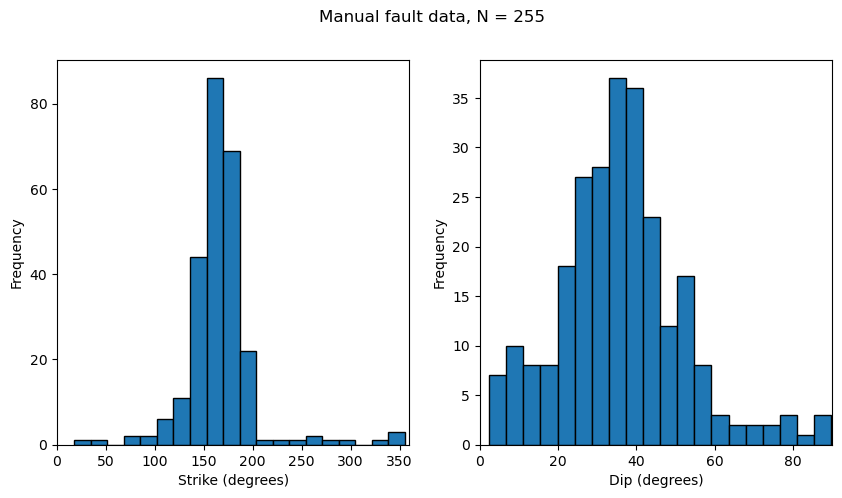

In [6]:
import matplotlib.pyplot as plt

# this makes visible our functions folder
sys.path.append(os.path.abspath(os.path.join('..', 'functions')))

from fit_plane import fit_plane

# calculate the orientation of the manual fault at the resampled points
# and where there are at least n points within a radius r from the point

n = 6 # minimum number of points to fit plane, needs to be >= 3
r = 100 # m, radius to consider points for fitting plane
r_squared = r**2 # square of the radius
strikes_manual = [] # list to store the strikes
dips_manual = [] # list to store the dips

for point in res_manual_fault:
    # find points within r_squared
    d_squared = ((manual_fault[:,0] - point[0])**2 + (manual_fault[:,1] - point[1])**2 
                + (manual_fault[:,2] - point[2])**2)
    indexes = np.where(d_squared < r_squared)[0]
    
    # if there are at least n points
    if len(indexes) >= n:
        # fit plane
        strike, dip, _ = fit_plane(manual_fault[indexes])
        # add to lists
        strikes_manual.append(strike)
        dips_manual.append(dip)

# convert strikes and dips from radians to degrees
strikes_manual = np.array(strikes_manual) * 180 / np.pi
dips_manual = np.array(dips_manual) * 180 / np.pi

# plot histograms of strikes and dips
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'Manual fault data, N = {strikes_manual.size}')

ax[0].hist(strikes_manual, bins=20, edgecolor='black')
ax[0].set_xlim(0, 360)
ax[0].set_xlabel('Strike (degrees)')
ax[0].set_ylabel('Frequency')

ax[1].hist(dips_manual, bins=20, edgecolor='black')
ax[1].set_xlim(0, 90)
ax[1].set_xlabel('Dip (degrees)')
ax[1].set_ylabel('Frequency')

plt.show()

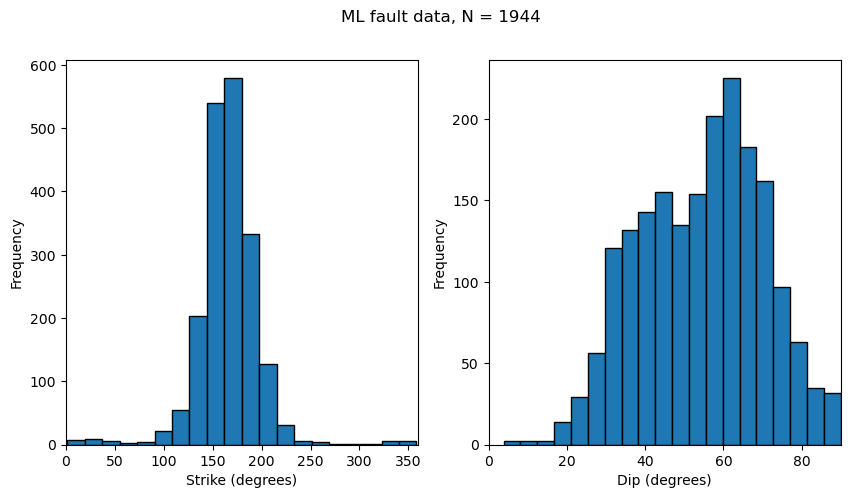

In [7]:
# calculate the orientation of the ML fault at the resampled points
# and where there are at least n points within a radius r from the point

strikes_ML = [] # list to store the strikes
dips_ML = [] # list to store the dips

for point in res_ML_fault:
    # find points within r_squared
    d_squared = ((ML_fault[:,0] - point[0])**2 + (ML_fault[:,1] - point[1])**2 
                + (ML_fault[:,2] - point[2])**2)
    indexes = np.where(d_squared < r_squared)[0]
    
    # if there are at least n points
    if len(indexes) >= n:
        # fit plane
        strike, dip, _ = fit_plane(ML_fault[indexes])
        # add to lists
        strikes_ML.append(strike)
        dips_ML.append(dip)

# convert strikes and dips from radians to degrees
strikes_ML = np.array(strikes_ML) * 180 / np.pi
dips_ML = np.array(dips_ML) * 180 / np.pi

# plot histograms of strikes and dips
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'ML fault data, N = {strikes_ML.size}')

ax[0].hist(strikes_ML, bins=20, edgecolor='black')
ax[0].set_xlim(0, 360)
ax[0].set_xlabel('Strike (degrees)')
ax[0].set_ylabel('Frequency')

ax[1].hist(dips_ML, bins=20, edgecolor='black')
ax[1].set_xlim(0, 90)
ax[1].set_xlabel('Dip (degrees)')
ax[1].set_ylabel('Frequency')

plt.show()

The manual and ML fault data show about the same distribution of strike, but the dip distributions are different. The ML fault data have a larger distribution of large (> 60°) dips. Is this true? Are the ML fault data sampling deeper, steeper fault regions than the manual data are not sampling?

Finally, let's plot the poles to the fault (both manual and ML) in equal area stereonets:

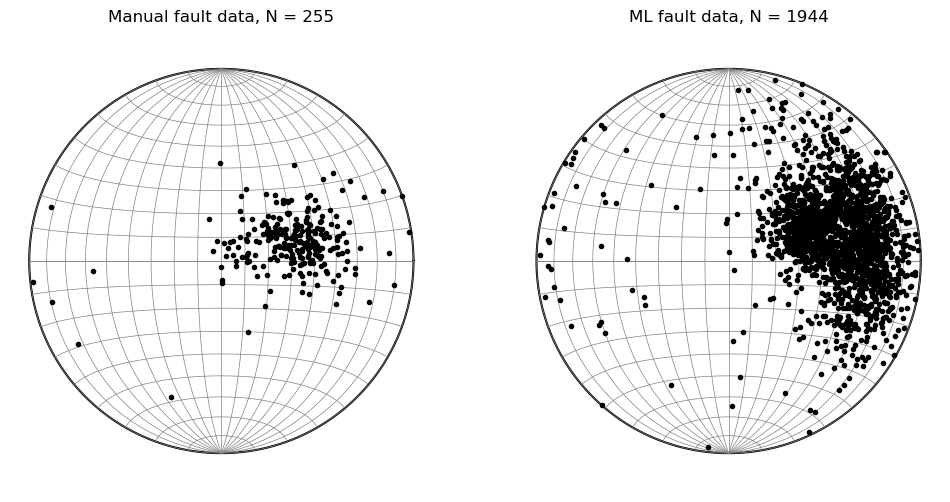

In [8]:
# Plot in equal stereonets the manual and ML fault orientation data
from pole import pole_from_plane
from st_coord_line import st_coord_line
from stereonet import stereonet

# plot data in equal stereonets
fig, ax = plt.subplots(1,2,figsize=(12,6))
strikes_list = [strikes_manual, strikes_ML]
dips_list = [dips_manual, dips_ML]
titles = [f'Manual fault data, N = {strikes_manual.size}', 
          f'ML fault data, N = {strikes_ML.size}']
for i in range(2):
    # stereonets
    stereonet(0,np.pi/2,np.radians(10),1,ax[i])
    ax[i].set_title(titles[i])
    # poles
    strikes = np.radians(strikes_list[i])
    dips = np.radians(dips_list[i])
    for j in range(strikes.size):
        trd, plg = pole_from_plane(strikes[j], dips[j])
        xp,yp = st_coord_line(trd,plg,1)
        ax[i].plot(xp,yp,"k.")

plt.show()

Clearly, the ML fault data have more steep orientations and a somewhat larger range of strikes. It could be interesting to color the points by depth (or elevation), to see if there is a correlation between dips and depth values. It could also be interesting to look at the variations (and distributions) of strike and dip for different values of the grid spacing, $r$ and $n$. Willl the strike and dip distributions stabilize and some value of $r$ ([Trede et al, 2019](https://njg.geologi.no/images/NJG_articles/NJG_Vol99_Nr3_Trede_etal.pdf))? These are your next tasks 🙂.

Is this useful are all? The short answer is yes. Fault stability analyses using limiting factors such as slip or dilation tendency, are dependent on the fault orientation. This is nicely analysed by [Michie et al. (2021)](https://library.seg.org/doi/abs/10.1190/INT-2021-0077.1). In a later notebook, I will also look at that.

Geometry is the starting point for many of the analyses in structural geology.

## Acknowledgements

The data used in this notebook were kindly provided by [Emma Michie](https://www.liverpool.ac.uk/people/emma-michie) at the University of Liverpool. I thank her for sharing the data.